# Quantifying volume transports across the osnap section in the VIKING20X model.


## Technical preample

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as c
import matplotlib.dates as mdates
import seaborn as sns
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
import itertools as it
import seawater as sw
from scipy import interpolate

import importlib
import sys

In [2]:
sys.path.append(r'../../src/')

import xorca_brokenline as bl
from xorca_lonlat2ij import get_ij

In [3]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")

rho_0 = 1000.0

In [4]:
from dask.distributed import Client

In [5]:
client = Client(n_workers=1, threads_per_worker=8, memory_limit=32e9)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/workshop007/proxy/8787/status,
Dashboard: /user/workshop007/proxy/8787/status,Workers: 1
Total threads: 8,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40595,Workers: 1
Dashboard: /user/workshop007/proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://134.245.214.97:40435,Total threads: 8
Dashboard: /user/workshop007/proxy/45279/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:38735,


_(Click on the link above if you want to see the Dask cluster in action.)_

## Parameters

Let's make it a habit to collect everyting we might want to change at a later point (the parameters of the analysis) in a central place.

In [6]:
# paramters

global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1"
restrict_years = "20??"  # restricts to 2014 to 2018
# restrict_years = "2014"  # restricts to 2014

project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

interim_data_path = Path('data/interim/')
section_data_path = Path('data/interim/section-data/')

figure_path = Path('reports/figures/')

external_data_path = Path('data/external/')
section_filename = 'osnap_pos_wp.txt'

# topo_smooth = 'none','5-cell-min','9-cell-min','9-cell-mean'
topo_smooth = '5-cell-min'


## Load VIKING20X data

We'll first find all the relevant files and then open them as a virtual contiguous dataset.

In [7]:
mesh_hgr_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_hgr*.nc")
mesh_hgr_files = list(sorted(mesh_hgr_files))
print(f"found {len(mesh_hgr_files)} mesh_hgr files")

mesh_zgr_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_zgr*.nc")
mesh_zgr_files = list(sorted(mesh_zgr_files))
print(f"found {len(mesh_zgr_files)} mesh_zgr files")

mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mask*.nc")
mask_files = list(sorted(mask_files))
print(f"found {len(mask_files)} mask files")

mesh_mask_files = (global_data_path / "mask" / experiment_id).glob(f"{nest_prefix}_mesh_mask*.nc")
mesh_mask_files = list(sorted(mesh_mask_files))
print(f"found {len(mesh_mask_files)} mesh mask files")

found 1 mesh_hgr files
found 1 mesh_zgr files
found 1 mask files
found 1 mesh mask files


In [8]:
mesh_hgr = xr.open_dataset(mesh_hgr_files[0],    
    chunks={
        "t": 1, "z": 64,
        "y": 256, "x": 1024
    },
)
mesh_zgr = xr.open_dataset(mesh_zgr_files[0],
    chunks={
        "t": 1, "z": 64,
        "y": 256, "x": 1024
    },
)
mask = xr.open_dataset(mask_files[0],
    chunks={
        "t": 1, "z": 64,
        "y": 256, "x": 1024
    },
)
mesh_mask = xr.open_dataset(mesh_mask_files[0],
    chunks={
        "z": 64,
        "y": 256, "x": 1024
    },
)

fmask = mesh_mask['fmask'].isel(z=0)

In [9]:
mesh_mask

<xarray.Dataset>
Dimensions:       (y: 2499, x: 2404, z: 46)
Dimensions without coordinates: y, x, z
Data variables: (12/44)
    nav_lon       (y, x) float32 dask.array<chunksize=(256, 1024), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(256, 1024), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(46,), meta=np.ndarray>
    time_counter  float64 ...
    tmask         (z, y, x) int8 dask.array<chunksize=(46, 256, 1024), meta=np.ndarray>
    umask         (z, y, x) int8 dask.array<chunksize=(46, 256, 1024), meta=np.ndarray>
    ...            ...
    gdepv         (z, y, x) float32 dask.array<chunksize=(46, 256, 1024), meta=np.ndarray>
    gdepw_0       (z, y, x) float32 dask.array<chunksize=(46, 256, 1024), meta=np.ndarray>
    gdept_1d      (z) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    e3t_1d        (z) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    e3w_1d        (z) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    depthw        (z) float64 dask.array<chunksize=(46,), meta=np.ndarray>
Attributes:
    history:  Mon Dec 16 12:47:29 2019: ncrename -v gdepw_1d,depthw /sfs/fs1/...
    NCO:      netCDF Operators version 4.8.1 (Homepage = http://nco.sf.net, C...

## Define a section along an isobath and find grid points along the section

### trying to build a section along the 1000 m contour and linked across 47 N. This also goes round a bit of Flemish Cap

In [10]:
# range of stations from west to east, stations 0-12. Python indexing.

def plotDepthContoursGrid():
    
    fig, ax = plt.subplots(figsize = (10,6))

    cs = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax,
         colors = 'grey', levels = [1000],zorder=1
    );

    cs1 = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax,
         colors = 'k', levels = [0.5],zorder=1
    );


# need to locate the right contour (use trial and error). each separate contour has separate index
# in this example identified as contour 0
# need the right contour numbers for main contour and Flemish Cap
# depends on smoothing method
#     for i in [0,71]: # topo_smooth == '9-cell-min' I think
    for i in [0,79]: # topo_smooth == '5-cell-min' I think
#     for i in [0,109]: # topo_smooth == 'none'
        v = cs.collections[0].get_paths()[i].vertices
        x = v[:,0]
        y = v[:,1]

        ax.plot(x,y,color='r')
    return cs

In [11]:
depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z").compute()

In [12]:
if topo_smooth == 'none':
    pass
elif topo_smooth == '9-cell-min':
    # 9-cell min
    depth = depth.rolling(x=3,center=True).min()
    depth = depth.rolling(y=3,center=True).min()
elif topo_smooth == '5-cell-min':
# 5-cell + shape min
    depth1 = depth.rolling(x=3,center=True).min()
    depth2 = depth.rolling(y=3,center=True).min()
    depth = np.minimum(depth1,depth2)
elif topo_smooth == '9-cell-mean':
    # 9-cell min
    depth = depth.rolling(x=3,center=True).mean()
    depth = depth.rolling(y=3,center=True).mean()
else:
    print('wrong smoothing parameter')
    exit()
    
    

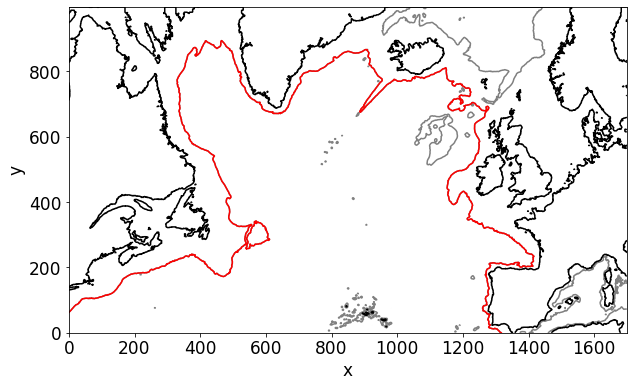

In [13]:
cs = plotDepthContoursGrid()

#### first the main 1000 m section

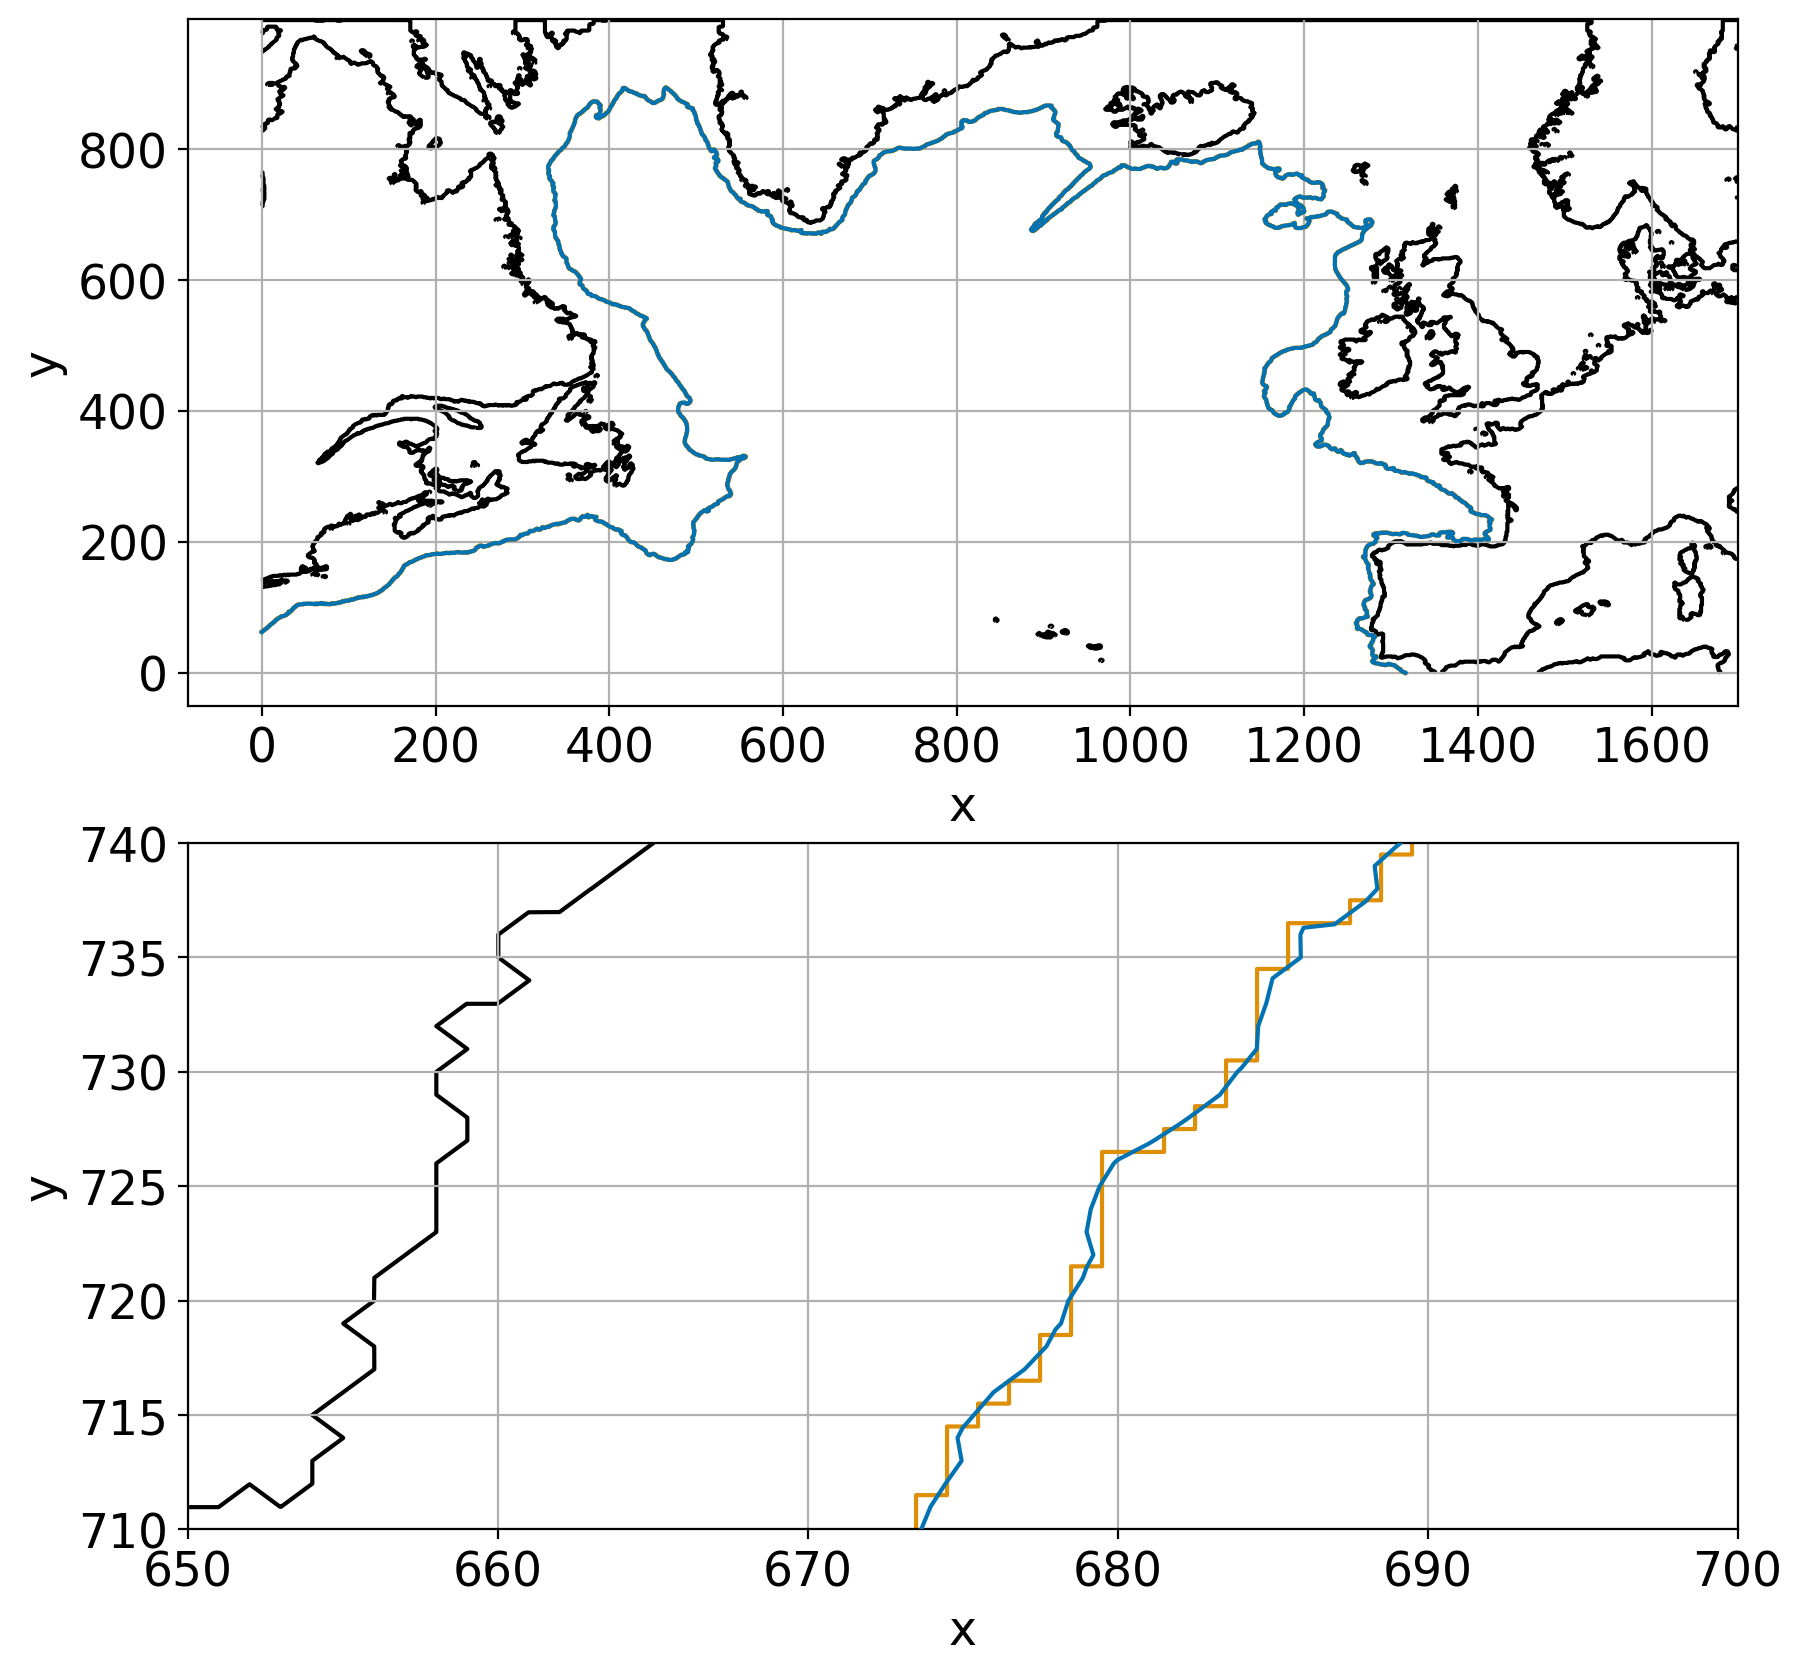

In [14]:
contours = [0,79]  # for topo_smooth == '5-cell-mean'

icontour = contours[0]

vs = cs.collections[0].get_paths()[icontour].vertices
fig, ax = plt.subplots(2,1,figsize = (10,10),dpi=200)
cs1 = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax[0],
     colors = 'k', levels = [0.5],zorder=1
);
cs2 = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax[1],
     colors = 'k', levels = [0.5],zorder=1
);

ax[0].plot(vs[:,0],vs[:,1],zorder=10)
ax[1].plot(vs[:,0],vs[:,1],zorder=10)

ax[0].grid()
ax[1].grid()

fs = []
v = vs[0]
if np.abs(np.round(v[0])-v[0]) < 0.0000001:
    a = [np.round(v[0])-1,np.trunc(v[1])]
    b = [np.round(v[0]),np.trunc(v[1])]
    fs.append(b)
    fs.append(a)

else:
    a = [np.trunc(v[0]),np.round(v[1])-1]
    b = [np.trunc(v[0]),np.round(v[1])]
    fs.append(a)
    fs.append(b)



for v in vs[1:]:
    if np.abs(np.round(v[0])-v[0]) < 0.0000001:
        a = [np.round(v[0])-1,np.trunc(v[1])]
        b = [np.round(v[0]),np.trunc(v[1])]
        if a == fs[-1]:
            fs.append(b)
        else:
            fs.append(a)
        
    else:
        a = [np.trunc(v[0]),np.round(v[1])-1]
        b = [np.trunc(v[0]),np.round(v[1])]
        if a == fs[-1]:
            fs.append(b)
        else:
            fs.append(a)
        
# for plotting offset to f points (f(i,j) is NE of T(i,j))
fs = np.array(fs)

# remove duplicates np.unique sorts by x value, want to retain original order, hence faff

# fsu,indices = np.unique(np.array(fs),axis=0,return_index=True)
# fsn=fs[np.sort(indices)]

ax[0].plot(fs[:,0]+0.5,fs[:,1]+0.5,color='C1')
ax[1].plot(fs[:,0]+0.5,fs[:,1]+0.5,color='C1')

ax[1].set_xlim(650,700)
ax[1].set_ylim(710,740)

# convert to full coordinates

fsn = fs.astype(int) + np.array([500,1500])

# plt.savefig('contour1000.png',dpi=300)


##### save only points north of 47 N

In [15]:
gphif = mesh_mask.gphif.data.compute()
glamf = mesh_mask.glamf.data.compute()

In [16]:
lat = [gphif[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]
lon = [glamf[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]

fsnda_main = xr.Dataset(data_vars=dict(fsn=(["ncount", "index"], fsn)))
fsnda_main = fsnda_main.assign({"lat":(("ncount"),lat)})
fsnda_main = fsnda_main.assign({"lon":(("ncount"),lon)})

In [17]:
fsnda_main = fsnda_main.where(fsnda_main.lat > 47).dropna('ncount', how='all')

In [18]:
fsnda_main.fsn

<xarray.DataArray 'fsn' (ncount: 4498, index: 2)>
array([[1841., 1794.],
       [1841., 1795.],
       [1840., 1795.],
       ...,
       [1036., 1792.],
       [1036., 1791.],
       [1036., 1790.]])
Dimensions without coordinates: ncount, index

#### flemish cap section

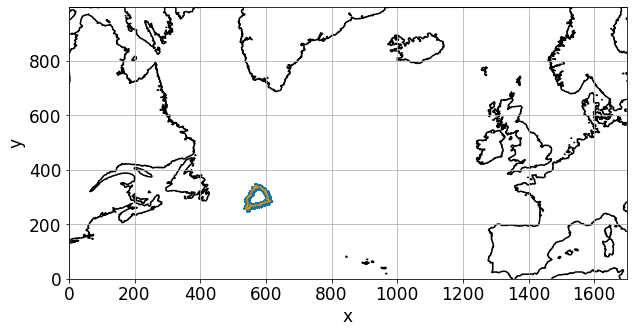

In [19]:
icontour = contours[1]

vs = cs.collections[0].get_paths()[icontour].vertices
fig, ax = plt.subplots(figsize = (10,5))
cs1 = depth.isel(y=slice(1500, 2499), x=slice(500, 2200)).plot.contour(ax=ax,
     colors = 'k', levels = [0.5],zorder=1
);

ax.plot(vs[:,0],vs[:,1],marker='+')

ax.grid()

fs = []
v = vs[0]
if np.abs(np.round(v[0])-v[0]) < 0.0000001:
    a = [np.round(v[0])-1,np.trunc(v[1])]
    b = [np.round(v[0]),np.trunc(v[1])]
    fs.append(b)
    fs.append(a)

else:
    a = [np.trunc(v[0]),np.round(v[1])-1]
    b = [np.trunc(v[0]),np.round(v[1])]
    fs.append(a)
    fs.append(b)



for v in vs[1:]:
    if np.abs(np.round(v[0])-v[0]) < 0.0000001:
        a = [np.round(v[0])-1,np.trunc(v[1])]
        b = [np.round(v[0]),np.trunc(v[1])]
        if a == fs[-1]:
            fs.append(b)
        else:
            fs.append(a)
        
    else:
        a = [np.trunc(v[0]),np.round(v[1])-1]
        b = [np.trunc(v[0]),np.round(v[1])]
        if a == fs[-1]:
            fs.append(b)
        else:
            fs.append(a)
        
# for plotting offset to f points (f(i,j) is NE of T(i,j))
fs = np.array(fs)

# remove duplicates np.unique sorts by x value, want to retain original order, hence faff

# fsu,indices = np.unique(np.array(fs),axis=0,return_index=True)
# fsn=fs[np.sort(indices)]

ax.plot(fs[:,0]+0.5,fs[:,1]+0.5,color='C1')

# convert to full coordinates

fsn = fs.astype(int) + np.array([500,1500])


##### save only points north of 47 N

In [20]:
lat = [gphif[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]
lon = [glamf[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]

fsnda_fcap = xr.Dataset(data_vars=dict(fsn=(["ncount", "index"], fsn)))
fsnda_fcap = fsnda_fcap.assign({"lat":(("ncount"),lat)})
fsnda_fcap = fsnda_fcap.assign({"lon":(("ncount"),lon)})

In [21]:

fsnda_fcap = fsnda_fcap.where(fsnda_fcap.lat > 47).dropna('ncount', how='all')

In [22]:
fsnda_fcap

<xarray.Dataset>
Dimensions:  (ncount: 210, index: 2)
Dimensions without coordinates: ncount, index
Data variables:
    fsn      (ncount, index) float64 1.042e+03 1.79e+03 ... 1.11e+03 1.787e+03
    lat      (ncount) float32 47.01 47.05 47.08 47.08 ... 47.05 47.01 47.01
    lon      (ncount) float32 -46.75 -46.75 -46.75 ... -43.33 -43.33 -43.28

#### gap to flemish cap (looked up manually)

In [23]:
# fsnda_fcap.fsn

In [24]:
# 9-cell-min
# fsn = np.array([[1037,1790],[1038,1790],[1039,1790],[1040,1790]])
# 5-cell-min
fsn = np.array([[1037,1790],[1038,1790],[1039,1790],[1040,1790],[1041,1790]])
# # topo_smooth == None
# fsn = np.array([[1036,1790],[1037,1790],[1038,1790],[1039,1790],[1040,1790],[1041,1790],[1042,1790]])


In [25]:
lat = [gphif[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]
lon = [glamf[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]

fsnda_fgap = xr.Dataset(data_vars=dict(fsn=(["ncount", "index"], fsn)))
fsnda_fgap = fsnda_fgap.assign({"lat":(("ncount"),lat)})
fsnda_fgap = fsnda_fgap.assign({"lon":(("ncount"),lon)})

In [26]:
fsnda_fgap

<xarray.Dataset>
Dimensions:  (ncount: 5, index: 2)
Dimensions without coordinates: ncount, index
Data variables:
    fsn      (ncount, index) int64 1037 1790 1038 1790 ... 1040 1790 1041 1790
    lat      (ncount) float32 47.01 47.01 47.01 47.01 47.01
    lon      (ncount) float32 -47.0 -46.95 -46.9 -46.85 -46.8

#### across 47N

In [27]:
# ji = bln.section_indices([(1111,1787),(1841,1794)])
ji = bl.section_indices([(1110,1787),(1841,1794)])
# ji = bl.section_indices([(1109,1787),(1846,1794)])

In [28]:
# fsn = np.array([x for x in bl.section_indices([(1111,1787),(1841,1794)])])
fsn = np.array([x for x in bl.section_indices([(1110,1787),(1841,1794)])])
fsn = fsn[1:]

In [29]:
lat = [gphif[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]
lon = [glamf[fsn[i,1],fsn[i,0]] for i in range(fsn.shape[0])]

fsnda_47no = xr.Dataset(data_vars=dict(fsn=(["ncount", "index"], fsn)))
fsnda_47no = fsnda_47no.assign({"lat":(("ncount"),lat)})
fsnda_47no = fsnda_47no.assign({"lon":(("ncount"),lon)})

In [30]:
fsnda_47no

<xarray.Dataset>
Dimensions:  (ncount: 738, index: 2)
Dimensions without coordinates: ncount, index
Data variables:
    fsn      (ncount, index) int64 1111 1787 1112 1787 ... 1840 1794 1841 1794
    lat      (ncount) float32 47.01 47.01 47.02 47.02 ... 47.02 47.01 47.01
    lon      (ncount) float32 -43.23 -43.18 -43.13 ... -5.888 -5.837 -5.786

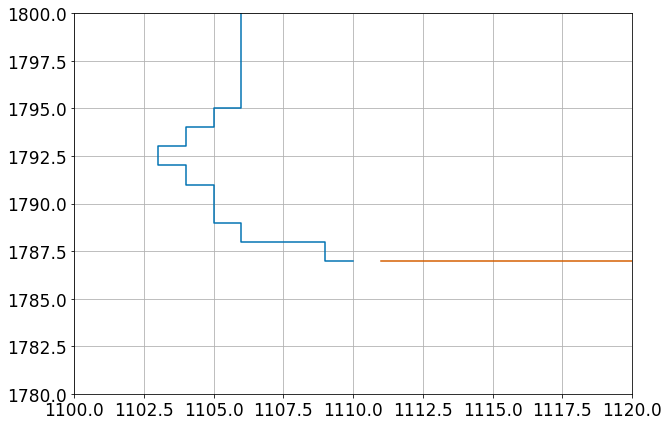

In [31]:
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(fsnda_fcap.fsn.isel(index=0),fsnda_fcap.fsn.isel(index=1))
ax.plot(fsnda_main.fsn.isel(index=0),fsnda_main.fsn.isel(index=1))
ax.plot(fsnda_fgap.fsn.isel(index=0),fsnda_fgap.fsn.isel(index=1))
ax.plot(fsnda_47no.fsn.isel(index=0),fsnda_47no.fsn.isel(index=1))
ax.set_xlim(1100,1120)
ax.set_ylim(1780,1800)
ax.grid()


In [32]:
fsnda = xr.concat((fsnda_main,fsnda_fgap,fsnda_fcap,fsnda_47no),'ncount')
fsnda

<xarray.Dataset>
Dimensions:  (ncount: 5451, index: 2)
Dimensions without coordinates: ncount, index
Data variables:
    fsn      (ncount, index) float64 1.841e+03 1.794e+03 ... 1.841e+03 1.794e+03
    lat      (ncount) float32 47.01 47.05 47.05 47.08 ... 47.02 47.01 47.01
    lon      (ncount) float32 -5.786 -5.783 -5.834 ... -5.888 -5.837 -5.786

In [33]:
fsnda

<xarray.Dataset>
Dimensions:  (ncount: 5451, index: 2)
Dimensions without coordinates: ncount, index
Data variables:
    fsn      (ncount, index) float64 1.841e+03 1.794e+03 ... 1.841e+03 1.794e+03
    lat      (ncount) float32 47.01 47.05 47.05 47.08 ... 47.02 47.01 47.01
    lon      (ncount) float32 -5.786 -5.783 -5.834 ... -5.888 -5.837 -5.786

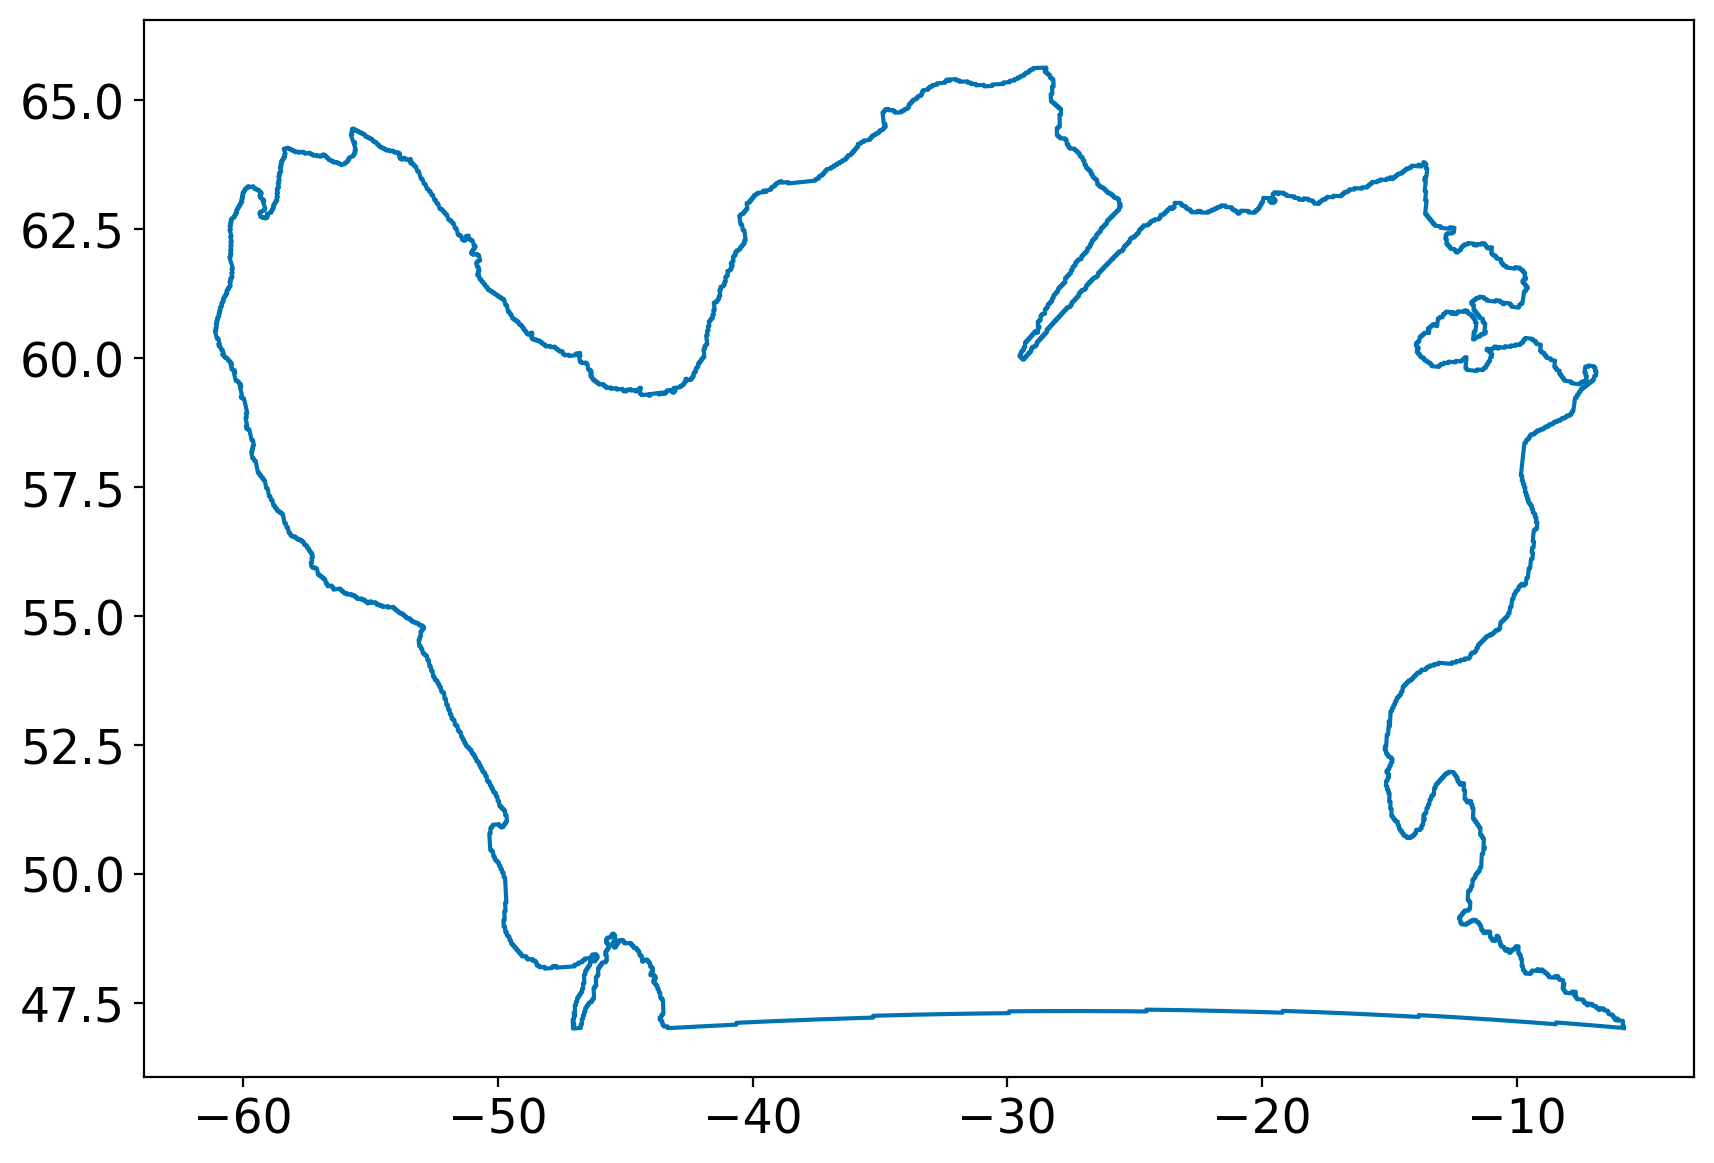

In [34]:
fig, ax = plt.subplots(figsize = (10,7),dpi=200)
ax.plot(fsnda.lon,fsnda.lat)
# plt.savefig('curtain.png',dpi=300)

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


make an iterator over (j,i) tuples over the section 

In [36]:
jjj=fsnda.fsn.isel(index=1).data.astype(int)
iii=fsnda.fsn.isel(index=0).data.astype(int)

In [37]:
# ji = bl.section_indices(ji_pairs=ji_pairs)
ji = it.zip_longest(jjj,iii)

In [38]:
for j,i in enumerate(range(1990,2020)):
    print(j,i)
    restrict_years = str(i)
    U_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_U.nc")
    U_files = list(sorted(U_files))
    print(i,f"found {len(U_files)} grid-U files")

    V_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_V.nc")
    V_files = list(sorted(V_files))
    print(i,f"found {len(V_files)} grid-V files")

    T_files = (global_data_path / "data" / experiment_id).glob(f"{nest_prefix}_{experiment_id}_1m_{restrict_years}????_{restrict_years}????_grid_T.nc")
    T_files = list(sorted(T_files))
    print(i,f"found {len(T_files)} grid-T files")

    gridU = xr.open_mfdataset(
        U_files,
        chunks={
            "time_counter": 1, "depthu": 64,
            "y": 256, "x": 1024
        },
        combine='by_coords'
    )

    gridV = xr.open_mfdataset(
        V_files,
        chunks={
            "time_counter": 1, "depthv": 64,
            "y": 256, "x": 1024
        },
        combine='by_coords'
    )
    gridT = xr.open_mfdataset(
        T_files,
        chunks={
            "time_counter": 1, "deptht": 64,
            "y": 256, "x": 1024
        },
        combine='by_coords'
    )

    gridU_processed, gridV_processed = bl.shift_grids(gridU=gridU, gridV=gridV, mesh_hgr=mesh_hgr,mesh_zgr=mesh_zgr,mask=mask,gridT=gridT)
    gridF_processed = bl.shift_grids_F(gridT=gridT, mesh_hgr=mesh_hgr,mesh_zgr=mesh_zgr,mask=mask)

    ji = it.zip_longest(jjj,iii)
    sectionU = bl.select_section(ji,gridU_processed,gridV_processed,mesh_hgr,mesh_zgr,mask).compute()
    sectionU_filename = 'v2022_05_16_01_sectionU_'+str(i)+'.nc'
    sectionU.to_netcdf(project_path / section_data_path / sectionU_filename)

    ji = it.zip_longest(jjj,iii)
    sectionF = bl.select_section_F(ji,gridF_processed,mesh_hgr,mesh_zgr,mask).compute()
    sectionF_filename = 'v2022_05_16_01_sectionF_'+str(i)+'.nc'
    sectionF.to_netcdf(project_path / section_data_path / sectionF_filename)


0 1990
1990 found 1 grid-U files
1990 found 1 grid-V files
1990 found 1 grid-T files
1 1991
1991 found 1 grid-U files
1991 found 1 grid-V files
1991 found 1 grid-T files
2 1992
1992 found 1 grid-U files
1992 found 1 grid-V files
1992 found 1 grid-T files
3 1993
1993 found 1 grid-U files
1993 found 1 grid-V files
1993 found 1 grid-T files
4 1994
1994 found 1 grid-U files
1994 found 1 grid-V files
1994 found 1 grid-T files
5 1995
1995 found 1 grid-U files
1995 found 1 grid-V files
1995 found 1 grid-T files
6 1996
1996 found 1 grid-U files
1996 found 1 grid-V files
1996 found 1 grid-T files
7 1997
1997 found 1 grid-U files
1997 found 1 grid-V files
1997 found 1 grid-T files
8 1998
1998 found 1 grid-U files
1998 found 1 grid-V files
1998 found 1 grid-T files
9 1999
1999 found 1 grid-U files
1999 found 1 grid-V files
1999 found 1 grid-T files
10 2000
2000 found 1 grid-U files
2000 found 1 grid-V files
2000 found 1 grid-T files
11 2001
2001 found 1 grid-U files
2001 found 1 grid-V files
2001

In [75]:
conda list

# packages in environment at /opt/tljh/user/envs/py3_euler_brokenline_2020.08.20.1:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       0_gnu    conda-forge
asciitree                 0.3.3                      py_2    conda-forge
attrs                     19.3.0                     py_0    conda-forge
backcall                  0.1.0                      py_0    conda-forge
basemap                   1.2.1            py37hd759880_1    conda-forge
bleach                    3.1.0                      py_0    conda-forge
blosc                     1.17.0               he1b5a44_1    conda-forge
bokeh                     1.4.0                    py37_0    conda-forge
boost-cpp                 1.70.0               h8e57a91_2    conda-forge
bzip2                     1.0.8                h516909a_2    conda-forge
ca-certificates           2019.11.28        